# Face Mask Detection

## Importing Essential Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
# Sklearn
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
# tensorflow & keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Input, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


## Data Preprocessing

In [2]:
directory = r"D:\\Popeye\\Face-Mask-Detection\\dataset"
categories = ["with_mask", "without_mask"]

# grab the list of images in out dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading  images...")

[INFO] loading  images...


In [3]:
data = []
labels = []

# looping first with mask and then without mask
# cat contains categories
for cat in categories:
    # joining path of with mask and without mask
    path = os.path.join(directory, cat)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        # converting an image into 224 by 224 size uniformly
        image = load_img(img_path, target_size=(224,224))
        # image to an array
        image = img_to_array(image)
        # preprocess input for using mobilenet model
        image = preprocess_input(image)
        
        data.append(image)
        labels.append(cat)


### Converting labels into number 

In [4]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

### Splitting the data into training and testing

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    labels, 
                                                    test_size=0.25, 
                                                    stratify=labels, 
                                                    random_state=42)

### Data Augmentation

In [7]:
aug = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
        )

## Creating MobileNetV2 network

In [10]:
from tensorflow.keras.layers import AveragePooling2D
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [12]:
# loop over all layers in the base model and freeze them so they will
# the actual model we will train
for layer in baseModel.layers:
    layer.trainable = False

In [13]:
# early_stopping
early_stopping = EarlyStopping(patience=5, 
                               min_delta=0.001,
                               restore_best_weights=True)

In [17]:
# compiling model
init_lr = 1e-4 # initial learning rate
epochs = 20 # epochs
batch_size = 32 # batch_size
print("[INFO] compiling the model...")

# optimizer
opt = Adam(lr=init_lr, decay=init_lr / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling the model...


In [21]:
# Training the model
print("[INFO] training...")
H = model.fit(
    aug.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch = len(X_train) // batch_size,
    validation_data = (X_test, y_test),
    validation_steps = len(X_test) // batch_size,
    epochs = epochs,
    callbacks = [early_stopping]
)

[INFO] training...
Epoch 1/20
89/89 [==============================] - 68s 768ms/step - loss: 0.2724 - accuracy: 0.9275 - val_loss: 0.1124 - val_accuracy: 0.9802
Epoch 2/20
89/89 [==============================] - 67s 755ms/step - loss: 0.1198 - accuracy: 0.9733 - val_loss: 0.0684 - val_accuracy: 0.9875
Epoch 3/20
89/89 [==============================] - 69s 779ms/step - loss: 0.0945 - accuracy: 0.9757 - val_loss: 0.0668 - val_accuracy: 0.9833
Epoch 4/20
89/89 [==============================] - 71s 798ms/step - loss: 0.0731 - accuracy: 0.9792 - val_loss: 0.0491 - val_accuracy: 0.9875
Epoch 5/20
89/89 [==============================] - 72s 808ms/step - loss: 0.0671 - accuracy: 0.9806 - val_loss: 0.0450 - val_accuracy: 0.9906
Epoch 6/20
89/89 [==============================] - 73s 825ms/step - loss: 0.0591 - accuracy: 0.9824 - val_loss: 0.0410 - val_accuracy: 0.9896
Epoch 7/20
89/89 [==============================] - 73s 817ms/step - loss: 0.0505 - accuracy: 0.9877 - val_loss: 0.0355 - v

## Model Evaluation

In [22]:
# making prediction on testing set
print("[INFO] evaluating network...")
pred = model.predict(X_test, batch_size=batch_size)

[INFO] evaluating network...


In [23]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probabilty
predID = np.argmax(pred,axis=1)

In [26]:
# Classification report
print(classification_report(y_test.argmax(axis=1), predID, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       479
without_mask       0.99      0.99      0.99       480

    accuracy                           0.99       959
   macro avg       0.99      0.99      0.99       959
weighted avg       0.99      0.99      0.99       959



In [29]:
# confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.argmax(axis=1), predID)
print(cm)

[[476   3]
 [  4 476]]


### Serialize the model to disk

In [30]:
print("[INFO] saving mask detection model...")
model.save("faceMask_detector.model", save_format="h5")

[INFO] saving mask detection model...


### Plot the training loss and accuracy

<Figure size 1368x576 with 0 Axes>

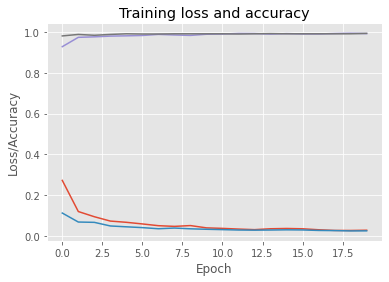

<Figure size 1368x576 with 0 Axes>

In [32]:
n = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,n),H.history["loss"], label="train_loss")
plt.plot(np.arange(0,n),H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,n),H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,n),H.history["val_accuracy"], label="val_acc")
plt.title("Training loss and accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.figure(figsize=(19,8))